# Проект "Исследование влияния подписки в рамках сервиса аренды самокатов GoFast"

## Описание проекта

В данном проекте нам предстоит анализ данных популярного сервиса аренды самокатов GoFast. В нашем распоряжении данные о некоторых пользователях из нескольких городов, а также об их поездках. 

Нам предстоит: 
1. Просмотреть имеющиеся данные;
2. Провести предобработку данных:
    - Проанализировать на предмет наличия явных и неявных дубликатов и обработать их;
    - Обработать имеющиеся в данных пропуски и заполнить их допустимыми значениями там, где это применимо;
    - Обновить типы значений столбцов при необходимости;
3. Исследовать и визуализировать следующие параметры:
    - Частота встречаемости городов;
    - Соотношение пользователей с подпиской и без подписки;
    - Возраст пользователей;
    - Расстояние, которое пользователь преодолел за одну поездку;
    - Продолжительность поездок.
4. Объединить все данные в одну таблицу и сделать первые выводы о разнице показателей разных групп пользователей.
5. Подсчитать помесячную выручку, а для этого изучить:
    - Суммарное расстояние для пользователя за каждый месяц;
    - Количество поездок;
    - Суммарное время;
    - Посчитать помесячную выручку для каждого пользователя.
6. Проверить несколько гипотез касательно наших данных:
    - Тратят ли пользователи с подпиской больше времени на поездки?
    - Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?
    - Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.
    - Техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест нам понадобится для проверки этой гипотезы?
7. Решить два дополнительных задания касательно стратегий маркетингового отдела.
8. Сделать общие выводы о проекте.

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
from numpy import random
from scipy import stats as st
from matplotlib import pyplot as plt


## Шаг 1. Загрузка данных

In [2]:
# получаем данные из имеющихся файлов

users = pd.read_csv('/datasets/users_go.csv')
users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [3]:
rides = pd.read_csv('/datasets/rides_go.csv')
rides.info()
rides.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [4]:
subs = pd.read_csv('/datasets/subscriptions_go.csv')
subs.info()
subs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


В нашем распоряжении три таблицы с данными.

- Первая таблица содержит уникальную идентификационную информацию о пользователях сервиса. Логично предположить, что количество строк в этой таблице - это количество уникальных пользователей.

- Вторая таблица содержит данные о количестве и характеристиках поездок, совершенных пользователями.

- Третья таблица учетная - в неё суказана информация о том, какая стоимость использования сервиса действует для двух типов подписки.
- Названия столбцов в таблицах достаточно релевантны, сходятся для одинаковых данных в разных таблицах и соответствуют snake_case. Изменений не требуется.
- Стоит также отметить, что во всех таблицах отсутствуют какие-либо пропуски.


## Шаг 2. Предобработка данных

Как мы отмечали ранее, в столбцах не были обнаружены пропуски, а значит этот этап мы можем пропустить.
Далее нам необходимо обработать явные и неявные дубликаты, а также изменить типы столбцов с данными, где это необходимо.

In [5]:
# для начала попробуем найти явные дубликаты
data_list = [users, rides, subs]
duplicates = []
for i in data_list:
    print(i[i.duplicated()])


      user_id        name  age            city subscription_type
1534      293       Агата   26       Краснодар             ultra
1535       16      Амалия   27       Краснодар             ultra
1536      909  Константин   20    Екатеринбург              free
1537      403      Полина   19            Сочи             ultra
1538      908      Рустам   30          Тюмень              free
1539       43    Стефания   22            Омск             ultra
1540      127       Павел   25       Пятигорск             ultra
1541      659       Злата   27  Ростов-на-Дону             ultra
1542      204      Руслан   30       Пятигорск             ultra
1543      153      Герман   23          Москва             ultra
1544     1245      Регина   27       Пятигорск              free
1545      807   Александр   28    Екатеринбург              free
1546      924       Мария   23       Пятигорск              free
1547      635      Герман   21          Москва             ultra
1548      136     Марсель

Как мы видим, явные дубликаты обнаружились только в первой таблице.  
Поскольку в ней должны содержаться только уникальные строки с учетными данными пользователей, мы можем смело удалить эти дубликаты.

In [6]:
users = users.drop_duplicates().reset_index(drop=True)


In [7]:
# теперь проверим на наличие неявных дубликатов
a = list(users['name'].unique())
sorted(a)


['Агата',
 'Аделина',
 'Адель',
 'Айдар',
 'Александр',
 'Александра',
 'Алексей',
 'Алина',
 'Алиса',
 'Алия',
 'Алла',
 'Альберт',
 'Альбина',
 'Алёна',
 'Амалия',
 'Амина',
 'Амир',
 'Анастасия',
 'Анатолий',
 'Ангелина',
 'Андрей',
 'Анжелика',
 'Анна',
 'Антон',
 'Антонина',
 'Ариана',
 'Арина',
 'Арсен',
 'Арсений',
 'Артемий',
 'Артур',
 'Артём',
 'Богдан',
 'Борис',
 'Вадим',
 'Валентина',
 'Валерий',
 'Валерия',
 'Варвара',
 'Василий',
 'Василина',
 'Василиса',
 'Вера',
 'Вероника',
 'Виктор',
 'Виктория',
 'Виолетта',
 'Виталий',
 'Виталина',
 'Влад',
 'Влада',
 'Владимир',
 'Владислав',
 'Владислава',
 'Всеволод',
 'Вячеслав',
 'Галина',
 'Георгий',
 'Герман',
 'Глеб',
 'Гордей',
 'Григорий',
 'Давид',
 'Дамир',
 'Даниил',
 'Данил',
 'Данила',
 'Даниэль',
 'Дарина',
 'Дарья',
 'Демид',
 'Денис',
 'Диана',
 'Дмитрий',
 'Ева',
 'Евгений',
 'Евгения',
 'Егор',
 'Екатерина',
 'Елена',
 'Елизавета',
 'Елисей',
 'Есения',
 'Жанна',
 'Зарина',
 'Захар',
 'Злата',
 'Иван',
 'Игнат',

In [8]:
a = list(users['city'].unique())
sorted(a)


['Екатеринбург',
 'Краснодар',
 'Москва',
 'Омск',
 'Пятигорск',
 'Ростов-на-Дону',
 'Сочи',
 'Тюмень']

Неявные дубликаты в этих столбцах не обнаружены, а в остальных таблицах нет столбцов, в которых могут встречаться такие дубликаты.  
Теперь приведём в соответствие типы столбцов к данным, которые в них содержатся. Большинство столбцов уже не противоречат своему содержанию за исключением столбца date. Переведем его в тип datetime.

In [9]:
rides['date'] = pd.to_datetime(rides['date'])


In [10]:
# проверим, за какой период мы имеем данные
display(rides['date'].min())
rides['date'].max()
# итого мы имеем данные только за один год

Timestamp('2021-01-01 00:00:00')

Timestamp('2021-12-30 00:00:00')

In [11]:
# создадим новый столбец, в котором будут храниться месяцы, в которых были совершены поездки
rides['date_month'] = rides['date'].dt.month
rides.head()


,user_id,distance,duration,date,date_month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


Предобработка данных завершена.
- Мы проверили имеющиеся таблицы на наличие пропусков. Они отсутствуют;
- Оценили наличие явных и неявных дубликатов. Явные дубликаты были удалены, неявные - не обнаружены;
- Привели типы столбцов в соответствие с содержащимися в них данными. Изменили столбец date на тип datetime и добавили отдельный столбец с номером месяца совершения поездки.

## Шаг 3. Исследовательский анализ данных

В исследовательской части нашего проекта нам небходимо оценить и визуализировать следующие параметры:
1. Частота встречаемости городов;
2. Соотношение пользователей с подпиской и без подписки;
3. Возраст пользователей;
4. Расстояние, которое пользователь преодолел за одну поездку;
5. Продолжительность поездок.

Начнём по порядку.

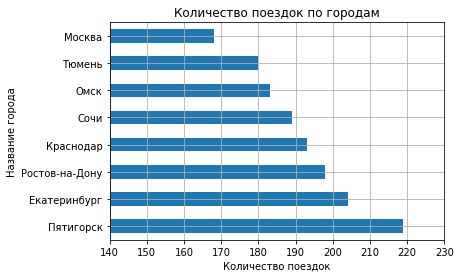

count      8.000000
mean     191.750000
std       15.672998
min      168.000000
25%      182.250000
50%      191.000000
75%      199.500000
max      219.000000
Name: city, dtype: float64

In [12]:
users['city'].value_counts().plot.barh(
    title='Количество поездок по городам',
    xlim=(140, 230),
    grid=True
)
plt.xlabel('Количество поездок')
plt.ylabel('Название города')
plt.show()

users['city'].value_counts().describe()


Как мы видим, наибольшее количество пользователей у нас в Пятигорске (219), наименьшее - в Москве (168). В среднем количество пользователей равно 194 со стандартным отклонением в 15,7. Различия между городами в количестве пользователей довольно невелико.

count      2.000000
mean     767.000000
std       96.166522
min      699.000000
25%      733.000000
50%      767.000000
75%      801.000000
max      835.000000
Name: subscription_type, dtype: float64

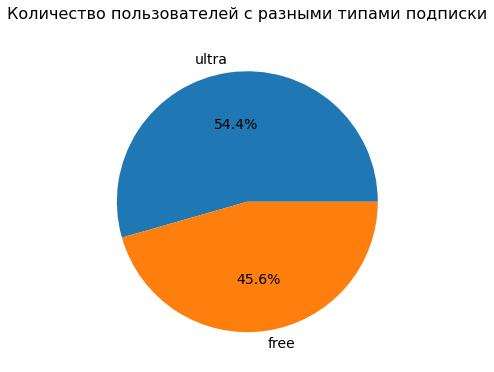

In [13]:
plt.figure(figsize=(6,6))

plt.pie(users['subscription_type'].value_counts(),
    labels=users['subscription_type'].unique(),
    autopct='%1.1f%%',
    textprops={'fontsize':14},
)

plt.title(
    label="Количество пользователей с разными типами подписки", 
    fontdict={"fontsize":16},
    pad=20
)

users['subscription_type'].value_counts().describe()

Как мы видим, пользователей без подписки чуть больше чем тех, кто имеет подписку - 835 против 699.

<BarContainer object of 29 artists>

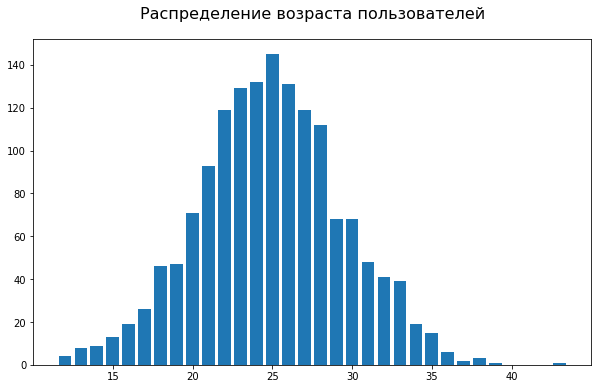

In [14]:
# теперь рассмотрим 
a = users.groupby('age')['user_id'].count()
b = a.index


plt.figure(figsize=(10, 6))
plt.title(
    label="Распределение возраста пользователей", 
    fontdict={"fontsize":16},
    pad=20
)
plt.bar(b, a)


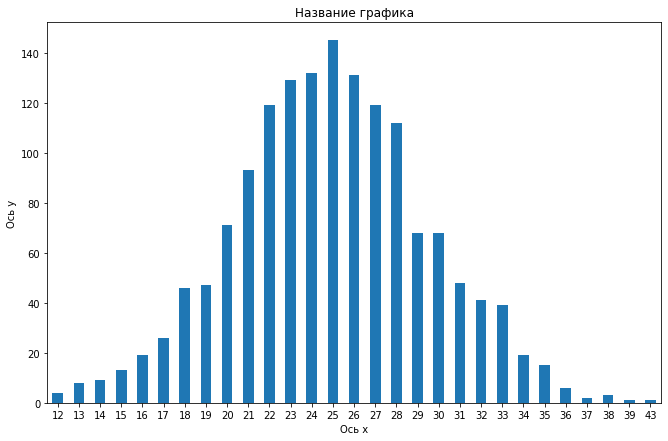

In [15]:
# код ревьюера

plt.figure(figsize=(11,7))
users.groupby('age')['user_id'].count().plot(kind='bar')

plt.title('Название графика')
plt.ylabel('Ось у')
plt.xlabel('Ось х')
plt.xticks(rotation=0)
plt.show()

In [16]:
a.describe()

count     29.000000
mean      52.896552
std       48.824280
min        1.000000
25%        9.000000
50%       41.000000
75%       93.000000
max      145.000000
Name: user_id, dtype: float64

Наиболее часто встречающийся возраст пользователей - 25 лет. Таких пользователей 145. Наиболее редко встречающийся - 39 и 43 года (по 1 пользователю). Всего в таблице имеется 29 различных возрастов от 12 до 43 лет.

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

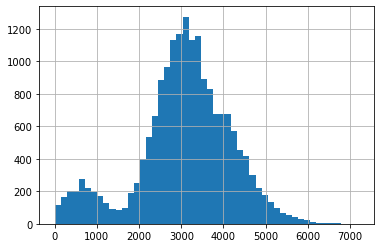

In [17]:
rides['distance'].hist(bins=50)
rides['distance'].describe()

Гистограмма даьности поездок говорит нам о том, что большинство пользователей перемещаются в среднем на расстояние около 3 километров. 
- Средняя дальность - 3070;
- Медиана - 3133;
- Стандартное отклонение - 1116;
- Расстояние варьируется от 0,86 до 7211 метров.

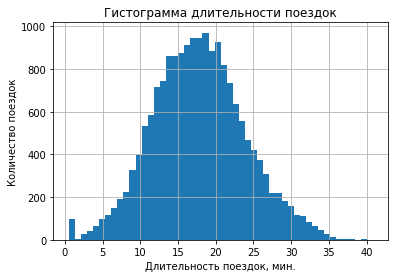

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

In [18]:
rides['duration'].hist(bins=50)
plt.title('Гистограмма длительности поездок')
plt.xlabel('Длительность поездок, мин.')
plt.ylabel('Количество поездок')
plt.show()

rides['duration'].describe()

In [19]:
display(rides[rides['duration'] < 2])
display(rides[rides['duration'] < 2]['duration'].unique())
rides[rides['duration'] < 2]['distance'].mean()

,user_id,distance,duration,date,date_month
6531,701,4196.445201,0.5,2021-08-31,8
6570,704,4830.824371,0.5,2021-10-14,10
6680,712,4684.004397,0.5,2021-03-04,3
6695,713,5215.642710,0.5,2021-02-25,2
6768,718,5197.436649,0.5,2021-02-11,2
...,...,...,...,...,...
17004,1460,5531.335845,0.5,2021-01-19,1
17242,1477,6724.932981,0.5,2021-01-12,1
17314,1483,4445.481070,0.5,2021-03-06,3
17505,1496,5722.551787,0.5,2021-02-14,2


array([0.5])

5113.176548536017

Исследовав более подробно этот пик около нуля, мы видим, что в нём содержатся 95 строк, длительность поездки в каждой из которых == 0.5, хотя расстояние у каждой поездки отличается. Более того, среднее расстояние для таких поездок более 5000 метров, что явно не соответствует указанной длительности.  
Так как количетство аномалий невелико, мы можем просто отбросить эти данные, чтобы уменьшить их влияние на дальнейший анализ.

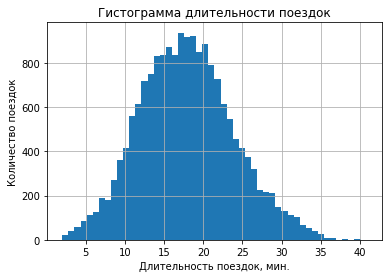

count    17973.000000
mean        17.896480
std          5.975424
min          2.035632
25%         13.670439
50%         17.714122
75%         21.747016
max         40.823963
Name: duration, dtype: float64

In [20]:
rides = rides[rides['duration'] >= 2]

rides['duration'].hist(bins=50)
plt.title('Гистограмма длительности поездок')
plt.xlabel('Длительность поездок, мин.')
plt.ylabel('Количество поездок')
plt.show()

rides['duration'].describe()

Продолжительность поездок в среднем составляет от 15 до 20 минут. 
- Средняя длительность - 17,8;
- Медиана - 17,7;
- Максимальная зафиксированная длительность - 41 минута, минимальная - 2,03;
- Стандартное отклонение - 5,97. 

Также виден небольшой пик около нуля. Возможно, он соответствует тем случаям, когда самокат взяли по ошибке, либо для того, чтобы добраться до другого самоката.

## Шаг 4. Объединение данных

Теперь объединим данные из всех трёх датафреймов в один.

In [21]:
data = rides.merge(users, on='user_id')
data = data.merge(subs, on='subscription_type')
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 17973 entries, 0 to 17972
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            17973 non-null  int64         
 1   distance           17973 non-null  float64       
 2   duration           17973 non-null  float64       
 3   date               17973 non-null  datetime64[ns]
 4   date_month         17973 non-null  int64         
 5   name               17973 non-null  object        
 6   age                17973 non-null  int64         
 7   city               17973 non-null  object        
 8   subscription_type  17973 non-null  object        
 9   minute_price       17973 non-null  int64         
 10  start_ride_price   17973 non-null  int64         
 11  subscription_fee   17973 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


Количество строк в получившейся таблице соответствует размерности таблицы rides, в которую мы добавляли данные. Соответственно, мы ничего не потеряли и не добавили лишнего.

Теперь выделим два отдельных датафрейма для пользователей с подпиской (ultra) и без (free) и визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.

In [22]:
data_free = data[data['subscription_type'] == 'free']
data_free.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11473 entries, 6500 to 17972
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11473 non-null  int64         
 1   distance           11473 non-null  float64       
 2   duration           11473 non-null  float64       
 3   date               11473 non-null  datetime64[ns]
 4   date_month         11473 non-null  int64         
 5   name               11473 non-null  object        
 6   age                11473 non-null  int64         
 7   city               11473 non-null  object        
 8   subscription_type  11473 non-null  object        
 9   minute_price       11473 non-null  int64         
 10  start_ride_price   11473 non-null  int64         
 11  subscription_fee   11473 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.1+ MB


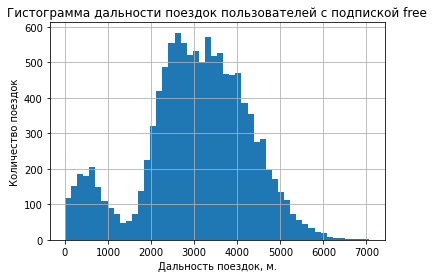

count    11473.000000
mean      3028.374239
std       1235.541051
min          0.855683
25%       2360.878149
50%       3102.083025
75%       3883.979311
max       7066.003772
Name: distance, dtype: float64

In [23]:
data_free['distance'].hist(bins=50)
plt.title('Гистограмма дальности поездок пользователей с подпиской free')
plt.xlabel('Дальность поездок, м.')
plt.ylabel('Количество поездок')
plt.show()

data_free['distance'].describe()

По этому графику мы видим, что характеристики распределения дальности поездок только для пользователей без подписки практически не изменились:
- Средняя дальность - 3028 против 3070;
- Медиана - 3102 против 3133;
- Стандартное отклонение - 1235 против 1116;
- Расстояние варьируется от 0,86 до 7066 метров.

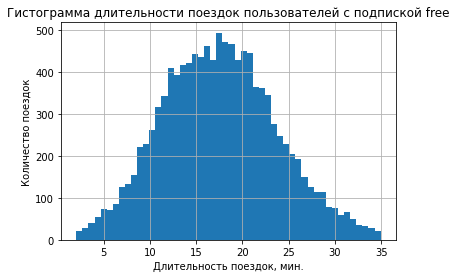

count    11473.000000
mean        17.530771
std          6.162609
min          2.035632
25%         13.085688
50%         17.383807
75%         21.638038
max         34.948498
Name: duration, dtype: float64

In [24]:
data_free['duration'].hist(bins=50)
plt.title('Гистограмма длительности поездок пользователей с подпиской free')
plt.xlabel('Длительность поездок, мин.')
plt.ylabel('Количество поездок')
plt.show()

data_free['duration'].describe()

Продолжительности поездок также не претерпели больших изменений.

- Средняя длительность - 17,5 против 17,8 у общей выборки;
- Медиана - 17,4 против 17,7;
- Максимальная зафиксированная длительность - 35 минута, минимальная - 2.0;
- Стандартное отклонение - 6,16 против 6.09. 

In [25]:
data_ultra = data[data['subscription_type'] == 'ultra']
data_ultra.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6500 entries, 0 to 6499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int64         
 1   distance           6500 non-null   float64       
 2   duration           6500 non-null   float64       
 3   date               6500 non-null   datetime64[ns]
 4   date_month         6500 non-null   int64         
 5   name               6500 non-null   object        
 6   age                6500 non-null   int64         
 7   city               6500 non-null   object        
 8   subscription_type  6500 non-null   object        
 9   minute_price       6500 non-null   int64         
 10  start_ride_price   6500 non-null   int64         
 11  subscription_fee   6500 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 660.2+ KB


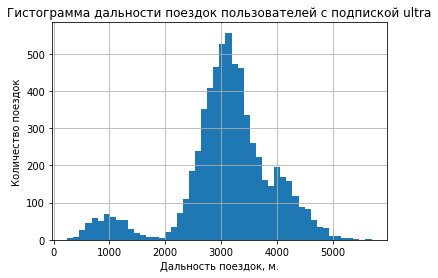

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

In [26]:
data_ultra['distance'].hist(bins=50)
plt.title('Гистограмма дальности поездок пользователей с подпиской ultra')
plt.xlabel('Дальность поездок, м.')
plt.ylabel('Количество поездок')
plt.show()

data_ultra['distance'].describe()

А вот данные для пользователей с подпиской:
- Средняя дальность - 3115 против 3070;
- Медиана - 3148 против 3133;
- Стандартное отклонение - 836 против 1116;
- Расстояние варьируется от 244 до 5699 метров.   

Мы видим, что хоть среднее и медиана также практически не отличаются, но вот разброс показателей значительно уменьшился - стандартное отклонение практически на 25% меньше аналогичного показателя общей выборки.

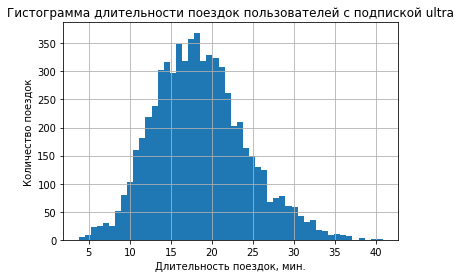

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

In [27]:
data_ultra['duration'].hist(bins=50)
plt.title('Гистограмма длительности поездок пользователей с подпиской ultra')
plt.xlabel('Длительность поездок, мин.')
plt.ylabel('Количество поездок')
plt.show()

data_ultra['duration'].describe()

Теперь рассмотрим показатели распределения длительности поездок пользователей с подпиской:
- Средняя длительность - 18,5 против 17,8 у общей выборки;
- Медиана - 18,18 против 17,7;
- Максимальная зафиксированная длительность - 41 минута, минимальная - 3.8;
- Стандартное отклонение - 5,6 против 6.09. 


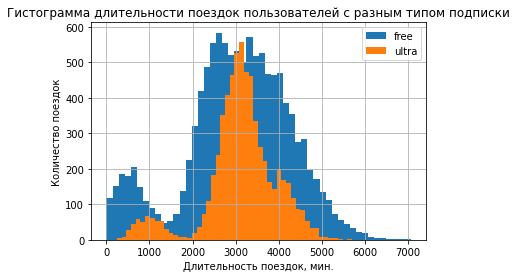

In [28]:
data_free['distance'].hist(bins=50)
data_ultra['distance'].hist(bins=50)
plt.title('Гистограмма длительности поездок пользователей с разным типом подписки')
plt.xlabel('Длительность поездок, мин.')
plt.ylabel('Количество поездок')
plt.legend(['free', 'ultra'])
plt.show()

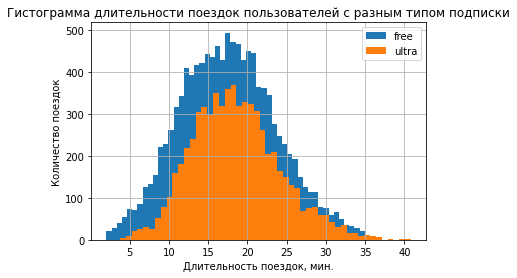

In [29]:
data_free['duration'].hist(bins=50)
data_ultra['duration'].hist(bins=50)

plt.title('Гистограмма длительности поездок пользователей с разным типом подписки')
plt.xlabel('Длительность поездок, мин.')
plt.ylabel('Количество поездок')
plt.legend(['free', 'ultra'])
plt.show()

**Промежуточный вывод:**  
Итак, мы разделили наш датасет по признаку наличия подписки у пользователя и визуализировали полученные показатели длительности и дальности поездок. Средняя длительность и медиана у пользователей с подпиской чуть выше чем у пользователей без подписки, а стандартное отклонение - меньше. Необходимо  оценить, действительно ли эта разница статистически значима. 

## Шаг 5. Подсчёт выручки

На данном этапе нам необходимо создать датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными, а также найти для каждого пользователя за каждый месяц:
- Суммарное расстояние;
- Количество поездок;
- Суммарное время.

Затем добавим столбец с помесячной выручкой, которую принёс каждый пользователь, с учетом того, какой вид подписки имеет пользователь.

In [30]:
# сгруппируем исходный датасет по идентификатору пользователя и месяца, в котором была совершена поездка
data_grouped = data.groupby(['user_id', 'date_month'])[['distance', 'duration']].sum()
data_grouped.head()

distance   duration
user_id date_month                        
1       1           7027.511294  41.416640
        4            754.159807   6.232113
        8           6723.470560  44.776802
        10          5809.911100  31.578017
        11          7003.499363  53.397424

In [31]:
# добавим столбец с количеством поездок пользователя за данный месяц
data_grouped['rides_count'] = data.groupby(['user_id', 'date_month'])['date_month'].count()


Для того, чтобы посчитать выручку, которую принёс каждый конкретный пользователь за каждый месяц, вернёмся к исходному датафрейму. Округлим количество потраченных минут (округляя вверх) и посчитаем стоимость каждой поездки, учитывая стоимость старта.

In [32]:
data['duration'] = np.ceil(data['duration']).astype('int')
data['ride_cost'] = data['duration'] * data['minute_price'] + data['start_ride_price']
data.head()

,user_id,distance,duration,date,date_month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,ride_cost
0,1,4409.919140,26,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199,156
1,1,2617.592153,16,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199,96
2,1,754.159807,7,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199,42
3,1,2694.783254,19,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199,114
4,1,4028.687306,27,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199,162


In [33]:
# теперь добавим в наш новый датасет, сгруппированный по пользователям и месяцам, суммарную стоимость поездок за месяц
# без учета стоимости подписки
data_grouped['month_cost'] = data.groupby(['user_id', 'date_month'])['ride_cost'].sum()
data_grouped.head()

distance   duration  rides_count  month_cost
user_id date_month                                                 
1       1           7027.511294  41.416640            2         252
        4            754.159807   6.232113            1          42
        8           6723.470560  44.776802            2         276
        10          5809.911100  31.578017            2         192
        11          7003.499363  53.397424            3         336

In [34]:
# теперь добавим в наш новый датафрейм столбец с уровнем подписки пользователей
data_ids = data[['user_id', 'subscription_type']].drop_duplicates().reset_index(drop=True)
data_ids

,user_id,subscription_type
0,1,ultra
1,2,ultra
2,3,ultra
3,4,ultra
4,5,ultra
...,...,...
1529,1530,free
1530,1531,free
1531,1532,free
1532,1533,free


In [35]:
# теперь добавим в наш новый датафрейм столбец с уровнем подписки пользователей

data_grouped.reset_index(inplace=True)
data_grouped = data_grouped.merge(data_ids, on='user_id')
data_grouped

,user_id,date_month,distance,duration,rides_count,month_cost,subscription_type
0,1,1,7027.511294,41.416640,2,252,ultra
1,1,4,754.159807,6.232113,1,42,ultra
2,1,8,6723.470560,44.776802,2,276,ultra
3,1,10,5809.911100,31.578017,2,192,ultra
4,1,11,7003.499363,53.397424,3,336,ultra
...,...,...,...,...,...,...,...
11295,1534,6,3409.468534,24.812678,2,308,free
11296,1534,8,7622.453034,47.205960,2,484,free
11297,1534,9,4928.173852,22.560373,1,234,free
11298,1534,11,13350.015305,76.342174,4,824,free


In [36]:
# для пользователей с подпиской добавим к поминутной месячной стоимости 199р - стоимость подписки
data_grouped.loc[data_grouped['subscription_type'] == 'ultra', 'month_cost'] = data_grouped['month_cost'] + 199
data_grouped

,user_id,date_month,distance,duration,rides_count,month_cost,subscription_type
0,1,1,7027.511294,41.416640,2,451,ultra
1,1,4,754.159807,6.232113,1,241,ultra
2,1,8,6723.470560,44.776802,2,475,ultra
3,1,10,5809.911100,31.578017,2,391,ultra
4,1,11,7003.499363,53.397424,3,535,ultra
...,...,...,...,...,...,...,...
11295,1534,6,3409.468534,24.812678,2,308,free
11296,1534,8,7622.453034,47.205960,2,484,free
11297,1534,9,4928.173852,22.560373,1,234,free
11298,1534,11,13350.015305,76.342174,4,824,free


Посмотрим на получившиеся данные и оценим, какую сумму в месяц в среднем тратит пользователь, имеющий подписку, и без неё.

count    4533.000000
mean      362.792191
std        88.262737
min       223.000000
25%       301.000000
50%       337.000000
75%       409.000000
max       955.000000
Name: month_cost, dtype: float64

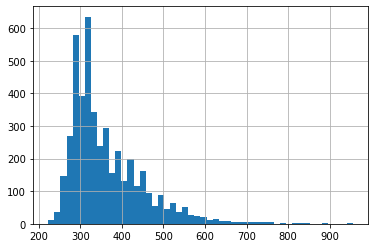

In [39]:
data_grouped[data_grouped['subscription_type'] == 'ultra']['month_cost'].hist(bins=50)
data_grouped[data_grouped['subscription_type'] == 'ultra']['month_cost'].describe()

count    6767.000000
mean      329.332644
std       183.268419
min        74.000000
25%       194.000000
50%       274.000000
75%       428.000000
max      1444.000000
Name: month_cost, dtype: float64

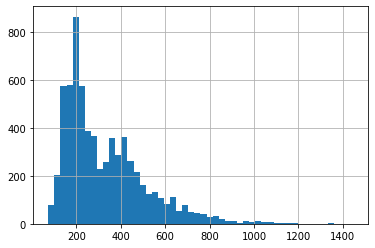

In [40]:
data_grouped[data_grouped['subscription_type'] == 'free']['month_cost'].hist(bins=50)
data_grouped[data_grouped['subscription_type'] == 'free']['month_cost'].describe()

Из получившихся данных мы видим, что характеристики распределения трат за месяц между подписок ultra и free отличаются следующим образом:
- Среднее 368 против 339 у подписки free;
- Медиана 337 против 284;
- Стандартное отклонение 93 против 190;
- Разброс значениий (223, 955) против (58, 1444).

Как мы видим, график для пользователей с платной подпиской показывает гораздо меньший разброс значений, то есть траты таких пользователей гораздо предсказуемее для бизнеса.

## Шаг 6. Проверка гипотез

На данном этапе проекта нам необходимо рассмотреть и проверить несколько гипотез: 
1. Тратят ли пользователи с подпиской больше времени на поездки?
2. Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?
3. Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.
4. Техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест нам понадобится для проверки этой гипотезы?

Начнём как всегда по порядку.

### Тратят ли пользователи с подпиской больше времени на поездки?

Итак проверим нашу гипотезу о том, что пользователи с подпиской ультра тратят больше времени на поездки чем без неё.  
Нулевая гипотеза будет звучать следующим образом:
- Пользователи с подпиской ультра тратят столько же времени на поездки, сколько и с подпиской free.

Альтернативная гипотеза:
- Пользователи с подпиской ультра тратят значимо больше времени на поездки, чем с подпиской free.

По умолчанию для всех гипотез будем брать уровень значимости alpha = 0.05.

In [41]:
alpha = 0.05

In [42]:
results = st.ttest_ind(data_ultra['duration'], data_free['duration'], alternative='greater')
# у нас нет оснований полагать, что дисперсии двух совокупностей значимо отличаются, поэтому параметр equal_var оставим по умолчанию True

print('Среднее значение длительности поездки для пользователей ultra:', data_ultra['duration'].mean())
print('Среднее значение длительности поездки для пользователей free:', data_free['duration'].mean())
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

Среднее значение длительности поездки для пользователей ultra: 18.54198516280583
Среднее значение длительности поездки для пользователей free: 17.530771268800226
p-значение: 4.704468074453899e-28
Отвергаем нулевую гипотезу


Итого мы можем сделать вывод, что для 5% уровня значимости наша изначальная гипотеза не подтвердилась, а значит мы берём альтернативную - пользователи с подпиской действительно тратят больше времени на поездки чем пользователи без неё.

### Превышает ли среднее расстояние 3130 метров?

Теперь проверим, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.

Нулевая гипотеза будет звучать следующим образом:
- Расстояние, которое проезжают пользователи с подпиской ультра равно 3130 метров.

Альтернативная гипотеза:
- Расстояние, которое проезжают пользователи с подпиской ультра больше 3130 метров.

In [43]:
distance_h0 = 3130
results = st.ttest_1samp(data_ultra['distance'], distance_h0, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


Наша нулевая гипотеза о том, что среднее расстояние не больше 3130 метров не была отпровержена, а значит средний износ не больше 3130 метров. За износ самокатов можно не переживать.

### Отличается ли помесячная выручка между группами пользователей?

Теперь разберемся с помесячной выручкой - будет ли она значимо выше для пользователей с подпиской чем для обычных пользователей.

Нулевая гипотеза будет звучать следующим образом:
- Помесячная выручка от пользователя с подпиской не отличается от пользователя без подписки.

Альтернативная гипотеза:
- Помесячная выручка от пользователя с подпиской больше чем от пользователя без подписки.

In [44]:
a = data_grouped.loc[data_grouped['subscription_type'] == 'ultra', 'month_cost']
b = data_grouped.loc[data_grouped['subscription_type'] == 'free', 'month_cost']

results = st.ttest_ind(a, b, alternative='greater')
# опять-таки у нас нет оснований полагать, что дисперсии двух совокупностей значимо отличаются

print('Среднее значение помесячной выручки для пользователей ultra:', a.mean())
print('Среднее значение помесячной выручки для пользователей free:', b.mean())

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

Среднее значение помесячной выручки для пользователей ultra: 362.7921906022502
Среднее значение помесячной выручки для пользователей free: 329.3326437121324
p-значение: 2.0314113674863288e-30
Отвергаем нулевую гипотезу


После проверки данной гипотезы с 5% уровнем значимости мы можем утверждать, что средняя месячная выручка от пользователей с подпиской значимо больше чем от пользователей без подписки.

### **И последний вопрос данного этапа, который мы должны обсудить - какой тест мы должны использовать в следующей ситуации?**

Техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него.

- Поскольку мы имеем по сути одну и ту же генеральную совокупность, с которой произошли некоторые изменения, и нам необходимо оценить значимость этих изменений, мы должны использовать гипотезу о равенстве зависимых (парных) выборок. В python это можно выполнить следующим методом
```
scipy.stats.ttest_rel(before, after)
```

**Промежуточный вывод по данному этапу**

В данном этапе мы рассмотрели три различных гипотезы и "проверили их на прочность". В результате мы получили:
1. Пользователи с подпиской действительно тратят статистически значимо больше времени на поездки, чем пользователи без неё.
2. Среднее время одной поездки значимо меньше оптимального с точки зрения износа самоката расстояния - 3130 метров. За излишний износ можно не переживать.
3. Помесячная выручка от пользователей с подпиской по месяцам значимо выше, чем выручка от пользователей без подписки.


## Шаг 7. Распределения

На данном этапе у нас есть два дополнительных задания.

### Первое задание:  
Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10% пользователей. Нам необходимо выяснить, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5%.

В данном случае мы явно имеем дело с биномиальным распределением, так как у каждого события только два исхода - продлит пользователь подписку или нет. У такого распределения только два параметра - вероятность положительного исхода (в данном случае 0.1), и общее количество экпериментов N - количество выданных промокодов, которое нам необходимо найти, чтобы выполнить план.  
По условию задачи, план - 100 клиентов, продливших подписку. Нам нужно найти такое распределение, чтобы вероятность исхода "99 или меньше пользователей продлили подписку" была около 5%.

Для упрощения нахождения некоторых параметров попробуем аппроксимировать наше биномиальное распределение нормальным.  
Это корректно только в том случае, когда промежуток от математического ожидания биномиального распределения плюс-минус три его стандартных отклонения лежит в пределах [0, n].

In [45]:
# возьмем приблизительное количество попыток, для которого вероятность не получить 100 продленных подписок будет довольно мала
n = 1200
p = 0.1

# найдем мат.ожидание и стандартное отклонение для нашего биномиального распределения
mu = n * p
std = (n * p * (1 - p))**0.5
display(mu - 3 * std, mu + 3 * std)
# оба значения лежат в пределах [0, n], поэтому аппроксимацию нормальным распределением можно продолжать

88.82308546376021

151.1769145362398

In [46]:
# теперь по характеристикам биномиального распределения построим нормальное
# найдём вероятность получить 99 или еще более меньшее значение клиентов, которые продлят подписку
plan = 99

distr = st.norm(mu, std) 
distr.cdf(plan)

0.021654071405395978

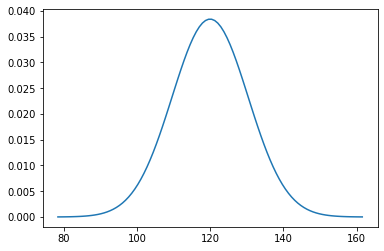

In [47]:
x = np.linspace(mu - 4*std, mu + 4*std, 100)
plt.plot(x, st.norm.pdf(x, mu, std))
plt.show()

В данном случае вероятность получить 99 клиентов или меньше оказалась == 2,1%. Необходимо изменить значение n, чтобы попасть ближе в целевой показатель в 5%.

In [48]:
n = 1160
p = 0.1

mu = n * p
std = (n * p * (1 - p))**0.5
display(mu - 3*std, mu + 3*std)

plan = 99

distr = st.norm(mu, std) 
distr.cdf(plan)

85.34710454133247

146.65289545866753

0.048077139371192464

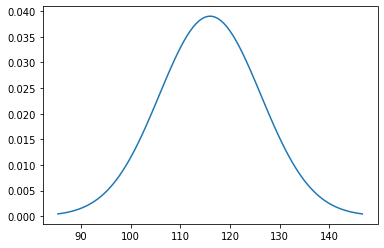

In [49]:
x = np.linspace(mu - 3*std, mu + 3*std, 100)
plt.plot(x, st.norm.pdf(x, mu, std))
plt.show()

Как мы видим из получившегося результата, при условии плана **получить не менее 100 клиентов, продливших подписку,** и вероятности этого события в 10% от каждого выданного промокода на бесплатный месяц , отделу маркетинга необходимо выдать 1160 купонов, чтобы вероятность не выполнить план была 4,8%.  
Будем считать, что дальнейший подбор значений не целесообразен и остановимся на этом показателе.

### **Второе задание для данного этапа звучит следующим образом.**

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40% получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации нужно построить примерный график распределения и оценить вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.


По аналогии с предыдущим заданием, в данном случае мы имеем аналогичное биномиальное распределение, которое удобно преобразовать в нормальное и использовать функцию cdf() для того, чтобы найти значение кумулятивное функции распределения в точке 399,5 тысяч.

In [51]:
# для начала также проверяем, что мы имеем право аппроксимировать это биномиальное распределение в нормальное
n = 1000000
p = 0.4

mu = n * p
std = (n * p * (1 - p))**0.5
display(mu - 3 * std, mu + 3 * std)

plan = 399500

distr = st.norm(mu, std) 
distr.cdf(plan)

398530.3061543301

401469.6938456699

0.15371708296369768

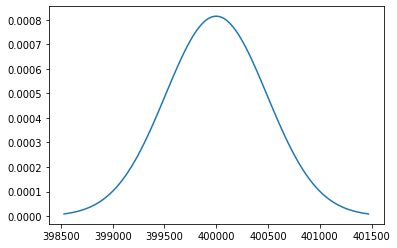

In [52]:
x = np.linspace(mu - 3*std, mu + 3*std, 100)
plt.plot(x, st.norm.pdf(x, mu, std))
plt.show()

Исходя из полученных данных мы видим, что вероятность того, что объявление откроют не более 399500 пользователей равна 15,37%.

## Общий вывод

В данном проекте мы анализировали данные популярного сервиса аренды самокатов GoFast. В нашем распоряжении имелись данные о некоторых пользователях из нескольких городов, а также о характеристиках их поездок. 

Наши результаты:  
1. Провели предобработку данных:
    - Проанализировать на предмет наличия явных и неявных дубликатов и обработали их, удалив;
    - Пропуски в данных обнаружены не были. Дополнительных действий не требовалось;
    - Обновили тип столбца date на datetime;
3. Исследовали и визуализировали следующие параметры:
    - Изучили частоту встречаемости городов. Наибольшее количество пользователей в Пятигорске (219), наименьшее - в Москве (168). Среднее - 194 со стандартным отклонением в 15,7. Различия между городами в количестве пользователей довольно невелико;
    - Пользователей без подписки чуть больше чем тех, кто имеет подписку - 835 против 699.;
    - Наиболее часто встречающийся возраст пользователей - 25 лет. Таких пользователей 145. Наиболее редко встречающийся - 39 и 43 года (по 1 пользователю). Всего в таблице имеется 29 различных возрастов от 12 до 43 лет.;
    - Изучили расстояние, которое пользователь преодолел за одну поездку. Средняя дальность - 3070. Медиана - 3133. Стандартное отклонение - 1116. Расстояние варьируется от 0,86 до 7211 метров.;
    - Также рассмотрели длительность поездок. Средняя длительность - 17,8. Медиана - 17,7. Максимальная зафиксированная длительность - 41 минута, минимальная - 2,3. Стандартное отклонение - 5,97.
4. Объединили все данные в одну таблицу и сделали промежуточные выводы о разнице показателей разных групп пользователей. Средняя длительность и медиана у пользователей с подпиской чуть выше чем у пользователей без подписки, а стандартное отклонение - меньше. 
5. Посчитали помесячную выручку и внесли её в таблицу, а для этого изучили:
    - Суммарное расстояние для пользователя за каждый месяц;
    - Количество поездок;
    - Суммарное время;
6. Проверили несколько гипотез касательно наших данных:
    - Пользователи с подпиской действительно тратят статистически значимо больше времени на поездки, чем пользователи без неё.
    - Гипотеза о том, что среднее расстояние не больше 3130 метров не была отпровержена, а значит средний износ не больше 3130 метров. За износ самокатов можно не переживать.
    - Помесячная выручка от пользователей с подпиской по месяцам значимо выше, чем выручка от пользователей без подписки.
7. Решили два дополнительных задания касательно стратегий маркетингового отдела.
    - При условии плана **получить не менее 100 клиентов, продливших подписку,** и вероятности этого события в 10% от каждого выданного промокода на бесплатный месяц , отделу маркетинга необходимо выдать 1160 купонов, чтобы вероятность не выполнить план была 4,8%.  
    - При рассылке 1млн. уведомлений и вероятности открыть каждое уведомление в 40%, вероятность того, что объявление откроют не более 399500 пользователей равна 15,37%.

Итого: задачи проекта выполнены, а цели достигнуты.